In [18]:
import requests # type: ignore
import pandas as pd # type: ignore
import psycopg2 # type: ignore
from psycopg2 import sql # type: ignore
from tqdm import tqdm # type: ignore
from datetime import datetime, timedelta
import random
import time
db_params = {
    "dbname": "jimarque",
    "user": "postgres",
    "password": "buddyrich134",
    "host": "localhost",
    "port": 5432
}
conn = psycopg2.connect(**db_params)
cursor = conn.cursor()

sql_str = """
select * from tpex_peratio order by da asc;
"""

cursor.execute(sql_str)
data = cursor.fetchall()
df = pd.DataFrame(data, columns=[i[0] for i in cursor.description])

df['da'] = pd.to_datetime(df['da'])

In [ ]:
s = pe_ratio.loc[i].dropna().replace(0, 1)
s = pe_ratio.loc[i].dropna().where(lambda x: x != 0, 1)  # 0 -> 1，其它不變
# 或
pe_ratio = pe_ratio.mask(pe_ratio == 0, 1)

In [29]:
len(pe_ratio.loc[i].dropna()), len(eps.loc[i].dropna())

(682, 682)

In [41]:
cl = df.pivot(index='da', columns='code', values='cl')
eps = df.pivot(index='da', columns='code', values='eps')
pe_ratio = df.pivot(index='da', columns='code', values='pe_ratio')

dates = cl.index[20:]
v = pd.DataFrame(index=cl.columns, columns=dates, dtype=float)
for d in dates:
    v[d] = (cl.loc[d].replace(0,1) * eps.loc[d].replace(0,1)) / pe_ratio.loc[d].replace(0,1)

In [44]:
# 0 當成 0，負值也歸 0，再按列相加做歸一化
w_long_only = v.T.clip(lower=0)
row_sum = w_long_only.sum(axis=1)
w_long_only = w_long_only.div(row_sum.replace(0, float("nan")), axis=0).fillna(0.0)


/var/folders/cb/s9sjq6dx01990v5hdvfhl7x40000gn/T/ipykernel_55328/3746181593.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  w_long_only = w_long_only.div(row_sum.replace(0, float("nan")), axis=0).fillna(0.0)


In [66]:
import numpy as np

# （可選）winsor 去極值，降低少數極端值的影響
r = v.rank(axis=1, method="average", na_option="keep")
r = -r
va = r.apply(pd.to_numeric, errors="coerce")
lo = va.T.quantile(0.01, axis=1)
hi = va.T.quantile(0.99, axis=1)
x = va.T.clip(lower=lo, upper=hi, axis=0)

# 列內標準化：z-score
mean = x.mean(axis=1)
std  = x.std(axis=1).replace(0, np.nan)
z = x.sub(mean, axis=0).div(std, axis=0)

# L1 歸一：讓每列 sum(|w|)=1（美元中性）
den = z.abs().sum(axis=1)
w_long_short = z.div(den.replace(0, np.nan), axis=0).fillna(0.0)


In [50]:
# 以排名代值，缺值保留；同名次取平均
r = v.rank(axis=1, method="average", na_option="keep")
w_rank = r.div(r.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0)


In [40]:
import pandas as pd
import numpy as np

# 逐欄插入，造成碎片
v = pd.DataFrame()
for k in range(1000):
    v[f'c{k}'] = np.arange(100)  # 一次插入一欄 → 很多小 blocks

def nblocks(df):
    # 內部屬性（非公開 API），只是用來觀察
    return len(df._mgr.blocks)

print("before copy, blocks =", nblocks(v))  # 很多

# 去碎片化
v = v.copy()
print("after copy,  blocks =", nblocks(v))  # 明顯變少（通常只剩幾個，依 dtype 而定）

before copy, blocks = 1000
after copy,  blocks = 1


/var/folders/cb/s9sjq6dx01990v5hdvfhl7x40000gn/T/ipykernel_55328/3158066322.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v[f'c{k}'] = np.arange(100)  # 一次插入一欄 → 很多小 blocks
/var/folders/cb/s9sjq6dx01990v5hdvfhl7x40000gn/T/ipykernel_55328/3158066322.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v[f'c{k}'] = np.arange(100)  # 一次插入一欄 → 很多小 blocks
/var/folders/cb/s9sjq6dx01990v5hdvfhl7x40000gn/T/ipykernel_55328/3158066322.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fr

In [67]:
import numpy as np
import pandas as pd

# 1) 清理
cl  = cl.sort_index().apply(pd.to_numeric, errors="coerce")
ret = cl.pct_change().replace([np.inf, -np.inf], np.nan)

w_applied = w_long_short.apply(pd.to_numeric, errors='coerce').astype('float64')
# 2) 對齊
w_applied = w_applied.reindex(index=ret.index, columns=ret.columns)

# >>> 新增：把 Decimal 轉 float <<<
w_applied = w_applied.apply(pd.to_numeric, errors='coerce').astype('float64')
ret         = ret.astype('float64')

# 3) 前視處理
w_lag = w_applied.shift(1).fillna(0)

# 4) 無報酬處置
w_lag = w_lag.where(~ret.isna(), 0)
ret   = ret.fillna(0)

# 5) 計算
port_ret = (w_lag * ret).sum(axis=1)
       # 每天的投組報酬（比例）
initial_capital = 1_000_000.0                # 你的本金（可調）
pnl = port_ret * initial_capital             # 每日損益（金額）
equity_curve = (1.0 + port_ret).cumprod() * initial_capital

# 6) 如需每資產逐日損益矩陣：
pnl_by_asset = w_lag * ret * initial_capital

# 7) （可選）交易成本/換手扣減
cost_per_turnover = 0.0005   # 例：單邊 5 bps
turnover = (w_applied.diff().abs().sum(axis=1) / 2.0).fillna(0)   # 單邊換手率
port_ret_net = port_ret - turnover * cost_per_turnover
pnl_net = port_ret_net * initial_capital
equity_curve_net = (1.0 + port_ret_net).cumprod() * initial_capital

# 8) 檢視結果
print("Daily return summary:\n", port_ret.describe())
print("Last 5 days PnL:\n", pnl.tail())
print("Last equity:\n", equity_curve.iloc[-1])


Daily return summary:
 count    2604.000000
mean        0.000135
std         0.001413
min        -0.006589
25%        -0.000755
50%         0.000115
75%         0.000960
max         0.006465
dtype: float64
Last 5 days PnL:
 da
2025-09-01     -44.105476
2025-09-02     517.170651
2025-09-03     743.476501
2025-09-04   -1956.921060
2025-09-05   -1800.561432
dtype: float64
Last equity:
 1418746.6492389282


/var/folders/cb/s9sjq6dx01990v5hdvfhl7x40000gn/T/ipykernel_55328/2430046005.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret = cl.pct_change().replace([np.inf, -np.inf], np.nan)


<Axes: xlabel='da'>

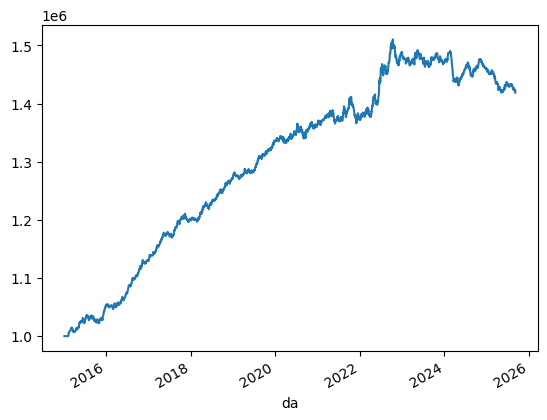

In [68]:
equity_curve.plot()

In [ ]:
w_long_only = w_long_only.apply(pd.to_numeric, errors='coerce').astype('float64')
